# Text summarization overview
Text Summarization can come in two main flavors. The first is extractive, which looks at the provided text, and selects some representative sentences from it. The other is abstractive, which generates its own sentences to summarize the provided text.

By necessity, a text summarizer takes in a sequence, read word by word, and outputs a sequence of a different length, making it a many to many problem, for which recurrent (LSTM) networks are particularly suited.

The network has two segments, the encoder and the decoder, which can each be any of Recurrent, LSTM, or Gated Recurrent networks. The encoder reads the input text, and generates an internal representation, which could be regarded as the machine's understanding or interpretation of the text as a whole. The decoder then takes this representation and tries to summarize it.

The main problem with encoder-decoders is that the entire input vector is converted and used for the decoder, which can result in very long sequences for it to memorize. We can reduce this effect by using an attention layer, which allows it to value some words over others as being more significant. Attention can be evaluated either locally or globally. This example will be global.

Basic diagram (I think)
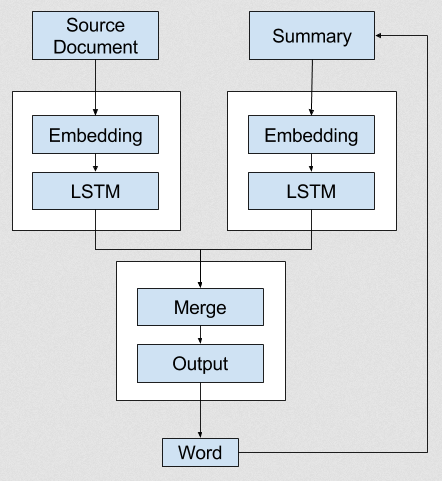

This example will be evaluation amazon fine food reviews, with data from https://www.kaggle.com/snap/amazon-fine-food-reviews

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

Importing and remove duplicates and missing info
- numpy,pandas: useful structures, math stuff
- re: use regular expressions to select and remove certain words
- keras: preprocessing, tokenizing, and making sequences uniform length
- nltk.corpus: predefined list of stopwords to exclude
- tensorflow.keras.layers: types of network layers to include
- tensorflow.keras.models: a model to add to and work on
- tensorflow.keras.callbacks: a way to stop the training early when it's no longer beneficial
- warnings: filter out warnings

In [18]:
from attention import AttentionLayer
#from tf.keras.layers import Attention

import os.path
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup

from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
# from tf.keras.preprocessing.text import Tokenizer
# from tf.keras.sequence import pad_sequence

from nltk.corpus import stopwords   

#from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
#from keras.models import Model
#from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("./data/amazon-fine-food-reviews/Reviews.csv", nrows=10000)
data.drop_duplicates(subset=["Text"], inplace=True) # what is subset?
data.dropna(axis=0, inplace = True)

We used pandas to read in the file, so it's represented as a data frame. I want to know what the columns are, though I don't care so much about the number of entries. 

"Text" refers to the content of the actual review, while "Summary" is an already-existing summary of the review. The first will be our input training data, and the second will be the training target.

In [4]:
print(data.columns)

print(data["Text"][0])
print(data["Summary"][0])

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Good Quality Dog Food


# Text Cleaning

To extract the meaning, we want to use mre standardized wordings, to reduce the complexity, and we don't care much about formatting, and we can get rid of the stopwords, which are grammatically necessary, but not very meaningful. So we can make everything lower case, get rid of contractions, parentheticals, and stopwords, turn plurals to singular, and get rid of special characters. We'll put this in a single function, since it's a conceptually contained step.
- Convert everything to lowercase
- Remove HTML tags
- Contraction mapping
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters
- Remove stopwords
- Remove short words

The contraction map was copied from the tutorial.

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [6]:
stop_words = set(stopwords.words("english"))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text # what does this do?
    newString = re.sub(r"\([^)]*\)", "", newString) # something with regular expressions
    newString = re.sub("''", "", newString)
    newString = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    
    # remove stopwords
    tokens = [w for w in newString.split() if not w in stop_words]
    
    # remove short words
    long_words = []
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return(" ".join(long_words)).strip()

cleaned_text = [text_cleaner(t) for t in data["Text"]]

# Summary Cleaning
The summaries are much the same as the text, but a bit shorter. (HOW ELSE ARE THEY DIFFERENT?)
Each summary entry, like the text entries, are just a string. Again we'll make everything lower case, remove html stuff, and any special characters. Also, append start and end tags to each summary entry (WHY NOT TO TEXT?).

In [7]:
data["Summary"][10]

'The Best Hot Sauce in the World'

In [8]:
def summary_cleaner(text):
    newString = re.sub('"', "", text) # get rid of quotes
    newString = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b", "", newString) # not sure what this does?
    newString = re.sub("[^a-zA-Z]", " ", newString) # replace any nonalphabetical characters with a space
    newString = newString.lower()
    tokens = newString.split() 
    newString = ""
    
    for i in tokens:
        if len(i)>1:
            newString = newString+i+" "
    return newString


cleaned_summary = [summary_cleaner(t) for t in data["Summary"]]

data["cleaned_text"]=cleaned_text
data["cleaned_summary"]=cleaned_summary
data["cleaned_summary"].replace("", np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [9]:
data["cleaned_summary"] = data["cleaned_summary"].apply(lambda x: "_START_" + x + "_END_")

for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_good quality dog food _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_not as advertised _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_delight says it all _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_cough medicine _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal

# Prepping data
We will need to split the data and the labels into training and testing sets. Then, the data will need to be tokenized (turned into numbers) and padded to be the same length.

In [10]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

Next we want to tokenize the texts and summaries. These turn the text into numerical sequences, referring to the indices of a dictionary. Numerical values are needed for the inputs and outputs of a neural network.

In [11]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# convert to integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

#print(y_tokenizer.index_word)
#print(x_tokenizer.index_word)
#print(x_tr)

Before we can use these tokens, we need to be sure that they are all the same length. We can achieve this by padding the shorter ones with null values. It is beneficial to cut down some of the longer entries to vastly reduce the amount of memory used for padding. A histogram will help to figure out which ones need cutting.

In [12]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

for i in data["cleaned_text"]:
    text_word_count.append(len(i.split()))
    
for i in data["cleaned_summary"]:
    summary_word_count.append(len(i.split()))
    
length_df = pd.DataFrame({"text":text_word_count, "summary":summary_word_count})
length_df.hist(bins = 30)
plt.show()

<Figure size 640x480 with 2 Axes>

In [13]:
max_len_text=80 
max_len_summary=10

# pad to uniform size
x_tr  = pad_sequences(x_tr,  maxlen=max_len_text, padding = "post")
x_val = pad_sequences(x_val, maxlen=max_len_text, padding = "post")

y_tr  = pad_sequences(y_tr,  maxlen=max_len_text, padding = "post")
y_val = pad_sequences(y_val, maxlen=max_len_text, padding = "post")

x_voc_size = len(x_tokenizer.word_index) + 1
y_voc_size = len(y_tokenizer.word_index) + 1

# Building the Model(s)

At this point, the data has been imported, cases changed, special characters removed, split into training and testing, and each entry in the original data set, for both texts and summaries have been turned into numerical encodings, and adjusted to be the same length.

Now, onto building and training the model. We will have three LSTM layers of 500 units for the encoder, followed by one for the decoder, and another for the attention layer. Note, that the process of training the model is somewhat different than using it, so we will later have to declare two other models for the encoder and decoder separately, in a way that maintains the trained model parameters. This is because training has a full input sequence and a full output sequence, while prediction/inference takes in a sequence and iteratively appends the next expected character to it. That is, while training, the encoder and decoder are each run once, while when predicting, the encoder is run once, while the decoder is run many times.

- Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep
-  Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only
-  Initial State: This is used to initialize the internal states of the LSTM for the first timestep
-  Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Embeddings are a way to represent a categorical variable as a vector of continuous values. This allows one to find a "distance" to neighbors and form clusters, to use categorical variables as an input to something like a neural network, and to visualize such variables on a convenient plot. The Embeddings are learned. Compared to one-hot encoding (a very simple embedding), embeddings are much smaller when there are a lot of unique entries, and because embbeddings are learned, number sequences that are similar represent similar categories. (model of an embedding?)

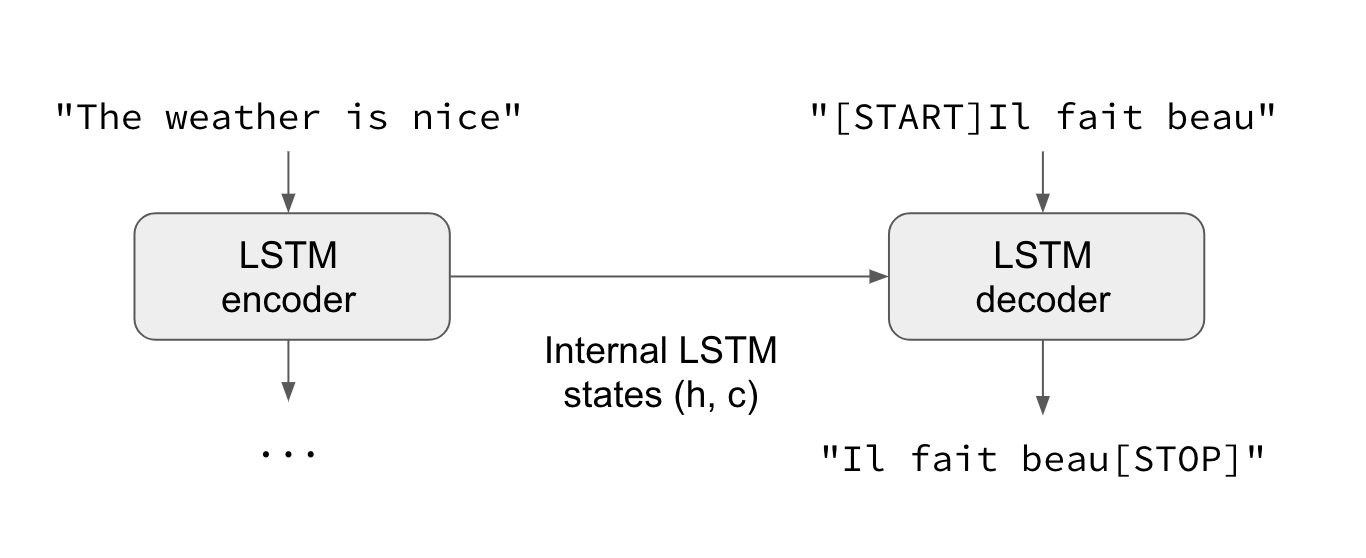


For each layer, we declare an LSTM or other type, with desired parameters, and then call that same layer, to split it up into its output, its hidden state, and its cell state. The outputs will be used to create the model

In [14]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Inputs and three layers of the encoder
encoder_inputs = Input(shape=(max_len_text,)) # WHAT DO THESE DO?
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)


encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)


encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer, takes the output both of the encoder and decoder
attn_layer = AttentionLayer(name="attention_layer")
attn_out, attn_states = attn_layer([encoder_output, decoder_outputs])

# Concatenation
decoder_concat_input = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attn_out])

# Dense Layer (Dense just applies activation function)
decoder_dense = TimeDistributed(Dense(y_voc_size, activation="softmax"))
decoder_outputs = decoder_dense(decoder_concat_input)

model=Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      8451000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
_____________________________________________________

This step will train the model, and stop early if the loss starts increasing.

In [19]:
if os.path.isfile("train_model.h5"):
    model = load_model("train_model.h5")
else: 
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=True)
    history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], epochs=10,callbacks=[es], batch_size=512, validation_data = ([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ValueError: Unknown layer: AttentionLayer

Get maps and reverse maps for the word to numerical tokenizer.

In [16]:
model.save("train_model.h5")


reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

Create a model each for the encoder and for the decoder.(WHAT IS THE FUNCTION OF THIS? WE ALREADY HAVE A MODEL) Because these two models are based on the same inputs, but have different (but appropriately sized) outputs, the model that we already trained is copied into separate encoder and decoder parts.

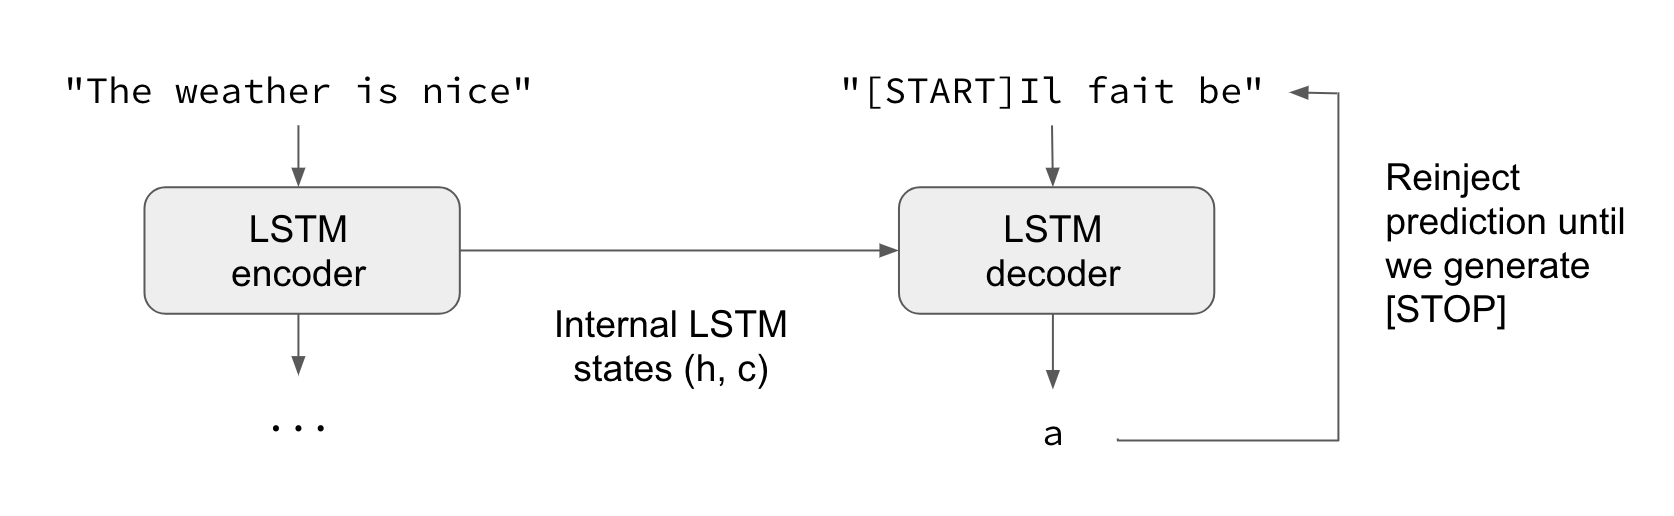

In [ ]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output, state_h, state_c])
encoder_model.save("text_encoder_NN.h5") # load with load_model("")

# decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# decoder embeddings
dec_emb2 = dec_emb_layer(decoder_inputs)

# predicting next word from decoder
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


# attention
attn_out_inf, atten_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

# use softmax layer to get probability distribution on the target vocabulary
decoder_outputs2 = decoder_dense(decoder_concat_input)

print()
print(type(decoder_inputs))
print()
print(dir(decoder_inputs))
print()
print(decoder_inputs.name)
print()
print(decoder_inputs)
print()
#help(tensorflow.python.framework.ops.Tensor)
#print()
#print(decoder_hidden_state_input)
#print()
#print(decoder_state_input_h)
#print()
#print(decoder_state_input_c)
#print()
#print(decoder_outputs2)
#print()
#print(state_h2)
#print()
#print(state_c2)

# Final Decoder
#decoder_model = Model(
#    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
#    [decoder_outputs2]) + [state_h2, 
#                          state_c2])

#decoder_model.save("text_decoder_NN.h5")

Now we declare the forward predictor. This is only useful after training. First it gets the encoder output, cell state and hidden state for decoding. (WHAT DOES `output_tokens` LOOK LIKE?). 

In [ ]:
def decode_sequence(input_seq):
    # encode the input
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0,0] = target_word_index["start"]
    
    stop_condition=False
    decoded_sentence=""
    while not stop_condition:
        # get words and states from decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        
        sampled_token_index = np.argmax(output_tokens[0,-1, :])
        
        if(sampled_token != "end"):
            decoded_sentence += " "+sampled_token
            
            if (sampled_token == "end" or len(decoded_sentence.split()) >= (max_len_summary-1))
                stop_condition=True
                
            
        # update the target sequence
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        e_h, e_c = h, c
    
    return decoded_sentence
            

Now we need to create two functions to map from the numerical tokens to actual text, and create some.

In [ ]:
def seq2summary(input_sequence):
    newString=""
    for i in input_sequence:
        if ((i!=0 and i!= tareget_word_index["start"] and i!= target_word_index["end"])):
            newString = newString + reverse_target_word_index[i] + " "
    return newString

def seq2text(input_sequence):
    newString=""
    for i in input_sequence:
        if (i!=0 ):
            newString = newString + reverse_source_word_index[i] + " "
    return newString

In [ ]:
for i in range(len(x_val)):
    print("Raw:" x_val)
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")